# Backtesting with zipline - Pipeline API with Custom Data

> This notebook requires the `conda` environment `backtest`. Please see the [installation instructions](../installation/README.md) for running the latest Docker image or alternative ways to set up your environment.

## Imports & Settings

In [1]:
from pathlib import Path
from collections import defaultdict
from time import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [2]:
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
np.random.seed(42)
idx = pd.IndexSlice

In [3]:
results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir()

## Alphalens Analysis

In [4]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [12]:
def get_trade_prices(tickers):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, '2010':'2018'], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [13]:
predictions = (pd.read_hdf(results_path / 'predictions.h5', 'predictions')
               .iloc[:, :4]
               .mean(1)
               .to_frame('prediction'))

In [14]:
factor = (predictions
          .unstack('symbol')
          .asfreq('D')
          .dropna(how='all')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('symbol').unique()

In [15]:
factor.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 893670 entries, (2011-04-27 00:00:00+00:00, A) to (2017-12-28 00:00:00+00:00, ZTS)
Data columns (total 1 columns):
prediction    893670 non-null float32
dtypes: float32(1)
memory usage: 6.8+ MB


In [16]:
trade_prices = get_trade_prices(tickers)

In [17]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2072 entries, 2010-01-04 to 2018-03-27
Columns: 600 entries, A to ZTS
dtypes: float64(600)
memory usage: 9.5 MB


In [18]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21)).sort_index()
factor_data.info()

Dropped 30.0% entries from factor data: 0.4% in forward returns computation and 29.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 625157 entries, (2011-04-27 00:00:00+00:00, A) to (2017-12-28 00:00:00+00:00, ZTS)
Data columns (total 6 columns):
1D                 625157 non-null float64
5D                 625157 non-null float64
10D                625157 non-null float64
21D                625157 non-null float64
factor             625157 non-null float32
factor_quantile    625157 non-null float64
dtypes: float32(1), float64(5)
memory usage: 28.6+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.005168,0.001667,0.000644,0.000625,125475,20.070958
2.0,-0.000586,0.001673,0.000684,0.000610,124853,19.971463
3.0,-0.000584,0.001677,0.000702,0.000606,124813,19.965065
4.0,-0.000582,0.001682,0.000715,0.000601,125301,20.043125
5.0,-0.000579,0.048656,0.000758,0.000784,124715,19.949389


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,-0.092,-0.123,-0.089,-0.059
beta,0.053,0.107,0.130,0.253
Mean Period Wise Return Top Quantile (bps),0.965,0.106,-0.185,-0.174
Mean Period Wise Return Bottom Quantile (bps),-1.500,-1.164,-1.533,-1.526
Mean Period Wise Spread (bps),2.465,1.244,1.315,1.322


Information Analysis


,1D,5D,10D,21D
IC Mean,0.008,0.011,0.015,0.014
IC Std.,0.143,0.139,0.137,0.128
Risk-Adjusted IC,0.056,0.079,0.108,0.106
t-stat(IC),1.926,2.697,3.675,3.610
p-value(IC),0.054,0.007,0.000,0.000
IC Skew,0.062,0.092,0.046,0.416
IC Kurtosis,0.351,0.730,0.265,0.631


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.236,0.480,0.604,0.708
Quantile 2 Mean Turnover,0.462,0.688,0.746,0.776
Quantile 3 Mean Turnover,0.497,0.709,0.761,0.783
Quantile 4 Mean Turnover,0.437,0.669,0.735,0.775
Quantile 5 Mean Turnover,0.218,0.455,0.582,0.691


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.876,0.588,0.388,0.194


<Figure size 432x288 with 0 Axes>

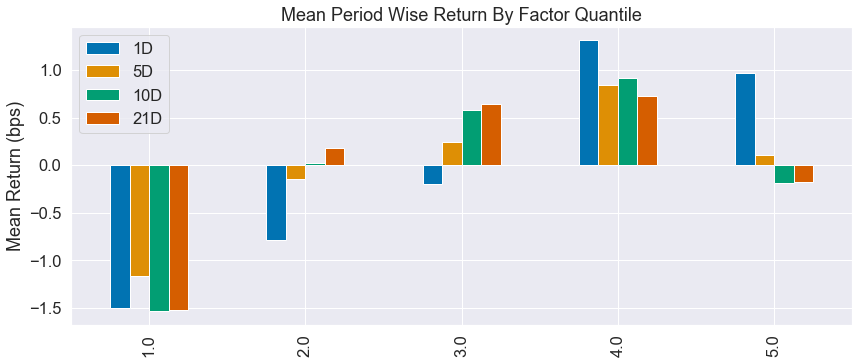

In [19]:
create_summary_tear_sheet(factor_data);

### Load zipline extensions

Only need this in notebook to find bundle.

In [20]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [21]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [22]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 10

## Load Data

### Quandl Wiki Bundel

In [23]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [26]:
def load_predictions(bundle):
    predictions = (pd.read_hdf(results_path / 'predictions.h5', 'predictions')
                   .iloc[:, :4]
                   .mean(1)
                   .to_frame('prediction'))
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [27]:
predictions, assets = load_predictions(bundle_data)

In [28]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1680 entries, 2011-04-27 to 2017-12-28
Columns: 600 entries, 0 to 3197
dtypes: float32(600)
memory usage: 3.9 MB


### Define Custom Dataset

In [29]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [30]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [31]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [32]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS),
        'shorts': signals.bottom(N_SHORTS)},
            screen=StaticAssets(assets))

## Initialize Algorithm

In [33]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.longs = context.shorts = None
    set_slippage(slippage.FixedSlippage(spread=0.00))
#     set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [34]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    longs = pipeline_output('signals').longs.astype(int)
    shorts = pipeline_output('signals').shorts.astype(int)
    holdings = context.portfolio.positions.keys()
    
    if longs.sum() > MIN_POSITIONS and shorts.sum() > MIN_POSITIONS:
        context.longs = longs[longs!=0].index
        context.shorts = shorts[shorts!=0].index
        context.divest = holdings - set(context.longs) - set(context.shorts)
    else:
        context.longs = context.shorts = pd.Index([])
        context.divest = set(holdings)

## Define Rebalancing Logic

In [35]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
          
    for stock in context.divest:
        order_target(stock, target=0)
    
#     log.warning('{} {:,.0f}'.format(len(context.portfolio.positions), context.portfolio.portfolio_value))
    if not (context.longs.empty and context.shorts.empty):
        for stock in context.shorts:
            order_target_percent(stock, -1 / len(context.shorts) / 2)
        for stock in context.longs:
            order_target_percent(stock, 1 / len(context.longs))

## Record Data Points

In [36]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [37]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [38]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2011-04-27
End:   2017-12-28


In [39]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2020-06-22 18:19:33.792272]: WARNING: ensure_benchmark_data: Still don't have expected benchmark data for 'SPY' from 1989-12-29 00:00:00+00:00 to 2020-06-22 00:00:00+00:00 after redownload!
[2020-06-22 18:20:34.915988]: WARNING: _can_order_asset: Cannot place order for ACE, as it has de-listed. Any existing positions for this asset will be liquidated on 2016-01-15 00:00:00+00:00.
[2020-06-22 18:20:43.103276]: WARNING: _can_order_asset: Cannot place order for RAX, as it has de-listed. Any existing positions for this asset will be liquidated on 2016-11-03 00:00:00+00:00.


Duration: 81.91s


## PyFolio Analysis

In [40]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [44]:
benchmark = web.DataReader('SP500', 'fred', '2010', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Plots

In [45]:
LIVE_DATE = '2018-01-01'

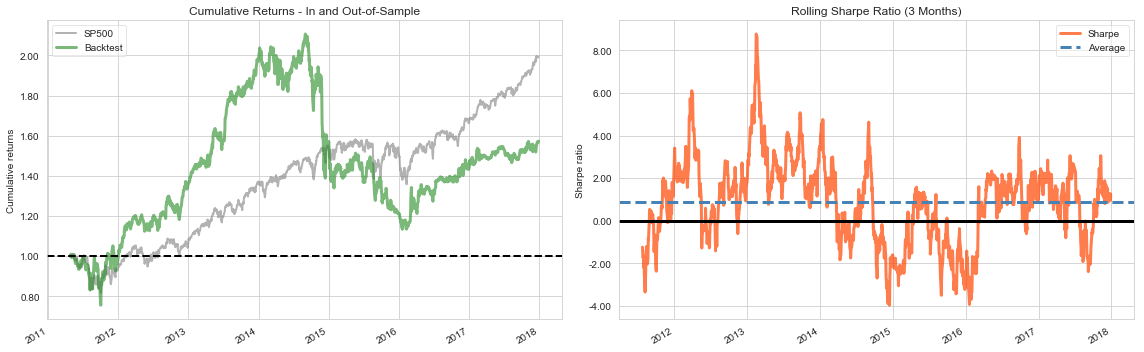

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                     ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig((results_path / 'pyfolio_out_of_sample').as_posix(), dpi=300)

### Tear Sheets

Start date,2011-04-27
End date,2017-12-28
Total months,80
,Backtest
Annual return,7.0%
Cumulative returns,57.2%
Annual volatility,19.8%
Sharpe ratio,0.44
Calmar ratio,0.15
Stability,0.15
Max drawdown,-46.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.19,2014-09-02,2016-01-20,NaT,NaN
1,25.15,2011-05-10,2011-10-03,2011-11-08,131
2,11.97,2011-12-05,2011-12-19,2012-01-12,29
3,10.90,2014-03-06,2014-06-03,2014-08-20,120
4,8.95,2012-09-21,2012-11-14,2012-12-05,54


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.32%,-7.64%,6.14%
EZB IR Event,-0.04%,-2.09%,1.47%
Apr14,-0.01%,-3.93%,2.62%
Oct14,-0.05%,-3.50%,3.17%
Fall2015,-0.19%,-2.29%,2.11%
Recovery,0.08%,-7.64%,6.47%
New Normal,0.02%,-9.53%,6.84%


Top 10 long positions of all time,max
sid,
SUNE,6.20%
WLT,6.11%
SPWR,5.90%
DNR,5.84%
VRTX,5.57%
BMRN,5.34%
CHK,5.22%
SPLK,5.18%
MU,4.95%


Top 10 short positions of all time,max
sid,
ACI,-3.09%
RH,-2.90%
SUNE,-2.84%
ILMN,-2.83%
TMUS,-2.64%
LNG,-2.64%
GMCR,-2.52%
DNR,-2.51%
AKS,-2.44%


Top 10 positions of all time,max
sid,
SUNE,6.20%
WLT,6.11%
SPWR,5.90%
DNR,5.84%
VRTX,5.57%
BMRN,5.34%
CHK,5.22%
SPLK,5.18%
MU,4.95%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,37883.00,20066.00,17817.00
Percent profitable,0.46,0.38,0.55
Winning round_trips,17417.00,7705.00,9712.00
Losing round_trips,18368.00,10347.00,8021.00
Even round_trips,2098.00,2014.00,84.00


PnL stats,All trades,Short trades,Long trades
Total profit,$69623.49,$-23046.85,$92670.34
Gross profit,$1421146.97,$412357.13,$1008789.84
Gross loss,$-1351523.47,$-435403.98,$-916119.50
Profit factor,$1.05,$0.95,$1.10
Avg. trade net profit,$1.84,$-1.15,$5.20
Avg. winning trade,$81.60,$53.52,$103.87
Avg. losing trade,$-73.58,$-42.08,$-114.22
Ratio Avg. Win:Avg. Loss,$1.11,$1.27,$0.91
Largest winning trade,$3585.00,$3342.91,$3585.00
Largest losing trade,$-5165.12,$-3583.37,$-5165.12


Duration stats,All trades,Short trades,Long trades
Avg duration,6 days 11:48:16.498033,5 days 12:32:07.918718,7 days 14:00:38.997474
Median duration,4 days 00:00:00,4 days 00:00:00,4 days 00:00:00
Longest duration,587 days 23:00:00,425 days 00:00:00,587 days 23:00:00
Shortest duration,0 days 00:00:00,0 days 00:00:00,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.00%,0.00%
Avg returns winning,0.06%,0.04%,0.07%
Avg returns losing,-0.05%,-0.03%,-0.08%
Median returns all round_trips,0.00%,-0.00%,0.00%
Median returns winning,0.02%,0.02%,0.03%
Median returns losing,-0.02%,-0.01%,-0.03%
Largest winning trade,2.41%,2.41%,2.03%
Largest losing trade,-3.19%,-2.71%,-3.19%


Symbol stats,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACE,ACI,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEO,AEP,AES,AET,AFL,AGCO,AGN,AGNC,AIG,AKAM,AKS,ALK,ALL,ALTR,ALXN,AMAT,AMD,AMG,AMGN,AMP,AMT,AMTD,AMZN,ANF,ANN,ANR,ANTM,AON,APA,APC,APD,APH,APOL,ARNC,ARO,ASH,ATI,ATVI,AVB,AVGO,AVP,AXP,AZO,BA,BAC,BAX,BBBY,BBT,BBY,BCR,BDX,BEAM,BEN,BG,BHI,BIDU,BIG,BIIB,BK,BLK,BLL,BMRN,BMY,BP,BRCD,BRCM,BRK_B,BSX,BWA,BXP,C,CA,CAG,CAH,CAM,CAR,CAT,CB,CBG,CBI,CCE,CCI,CCL,CDE,CE,CELG,CERN,CF,CFN,CHK,CHKP,CHRW,CHTR,CI,CIEN,CIT,CL,CLF,CLR,CLX,CMA,CMCSA,CMCSK,CME,CMG,CMI,CMS,CNC,CNP,CNX,COF,COG,COH,COL,COP,COST,COV,CPB,CPN,CREE,CRM,CSCO,CSX,CTL,CTSH,CTXS,CVS,CVX,CXO,CY,D,DAL,DATA,DD,DE,DECK,DF,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISH,DKS,DLPH,DLR,DLTR,DNR,DO,DOV,DOW,DPS,DRI,DTE,DTV,DUK,DVA,DVN,EA,EBAY,ECL,ED,EIX,EL,EMC,EMN,EMR,ENDP,EOG,EQIX,EQR,EQT,ES,ESI,ESRX,ESS,ESV,ETFC,ETN,ETR,EW,EXC,EXPD,EXPE,F,FANG,FAST,FB,FCX,FDO,FDX,FE,FFIV,FIS,FISV,FITB,FL,FLR,FLS,FLT,FOSL,FOX,FOXA,FRX,FSLR,FST,FTI,GCI,GD,GE,GILD,GIS,GLW,GM,GMCR,GME,GNW,GOLD,GOOGL,GPS,GRMN,GRPN,GS,GT,GWW,HAL,HAS,HBAN,HBI,HCA,HCBK,HCN,HCP,HD,HES,HFC,HLF,HOG,HOLX,HON,HOT,HP,HPQ,HRB,HSH,HSP,HST,HSY,HTZ,HUM,IBM,ICE,IGT,ILMN,INCY,INTC,INTU,IP,IPG,IR,ISRG,ITT,ITW,IVZ,JBHT,JBL,JBLU,JCI,JCP,JDSU,JEC,JNJ,JNPR,JOY,JPM,JWN,K,KBH,KBR,KEY,KIM,KLAC,KMB,KMI,KMX,KO,KORS,KR,KSS,KSU,KWK,L,LB,LBTYA,LEA,LEN,LH,LINTA,LLL,LLTC,LLY,LM,LMT,LNC,LNG,LNKD,LO,LOW,LRCX,LUV,LVLT,LVS,LXK,LYB,M,MA,MAN,MAR,MAS,MAT,MBI,MCD,MCHP,MCK,MCO,MCP,MDLZ,MDR,MDT,MET,MGM,MHFI,MHK,MJN,MLM,MMC,MMM,MNK,MNST,MO,MON,MOS,MPC,MRK,MRO,MRVL,MS,MSFT,MSI,MTB,MU,MUR,MWW,MXIM,MYL,NAV,NBL,NBR,NDAQ,NE,NEE,NEM,NFLX,NFX,NKE,NLSN,NLY,NOC,NOV,NOW,NRG,NSC,NTAP,NTRS,NU,NUAN,NUE,NVDA,NVR,NWL,O,OAS,OCR,ODP,OI,OKE,OMC,ONNN,ORCL,ORLY,OXY,P,PANW,PAYX,PBCT,PCAR,PCG,PCL,PCLN,PCP,PEG,PEP,PETM,PFE,PFG,PG,PGR,PH,PHM,PII,PLCM,PLD,PM,PNC,PNR,PNRA,PPG,PPL,PRGO,PRU,PSA,PSX,PTEN,PVH,PWR,PX,PXD,QCOM,QEP,QLGC,RAD,RAI,RAX,RCL,RDC,REGN,RF,RFMD,RH,RHT,RIG,RL,ROK,ROP,ROST,RRC,RSG,RSH,RTN,RVBD,S,SBAC,SBUX,SCCO,SCHW,SE,SEE,SHLD,SHW,SIAL,SIG,SIRI,SJM,SLB,SLG,SLM,SM,SNDK,SO,SPG,SPLK,SPLS,SPWR,SRE,STI,STJ,STLD,STR,STT,STX,STZ,SUNE,SVU,SWK,SWKS,SWN,SWY,SYK,SYMC,SYY,T,TAP,TDC,TDG,TDW,TEL,TER,TEX,TGNA,TGT,THC,TIBX,TIF,TJX,TMO,TMUS,TOL,TRIP,TROW,TRUE,TRV,TRW,TSCO,TSLA,TSN,TSO,TWC,TWTR,TWX,TXN,TXT,TYC,UAA,UAL,ULTA,UNH,UNM,UNP,UPL,UPS,URBN,URI,USB,UTHR,UTX,V,VAR,VFC,VIAB,VLO,VMC,VMW,VNO,VOD,VRSN,VRTX,VRX,VTR,VZ,WAG,WAT,WBA,WDAY,WDC,WEC,WFC,WFM,WHR,WLL,WLT,WM,WMB,WMT,WU,WY,WYN,WYNN,X,XEC,XEL,XL,XLNX,XOM,XRX,YELP,YHOO,YUM,ZBH,ZION,ZMH,ZTS
Avg returns all round_trips,0.00%,-0.00%,-0.00%,0.01%,0.00%,-0.00%,0.00%,0.00%,-0.07%,0.00%,0.00%,-0.00%,0.00%,-0.00%,-0.00%,0.00%,0.01%,0.00%,0.01%,-0.00%,0.00%,-0.00%,0.00%,0.00%,0.00%,0.00%,-0.04%,0.00%,0.01%,-0.02%,0.01%,0.00%,-0.01%,-0.01%,-0.00%,0.01%,0.00%,-0.00%,0.01%,0.01%,0.07%,-0.03%,-0.01%,0.00%,-0.00%,-0.01%,0.01%,-0.01%,-0.01%,-0.00%,-0.00%,-0.01%,0.00%,0.00%,0.00%,-0.02%,-0.01%,0.02%,-0.01%,0.01%,-0.00%,0.02%,-0.01%,-0.02%,-0.01%,-0.02%,-0.01%,-0.03%,0.00%,-0.00%,-0.01%,-0.01%,-0.02%,-0.01%,0.00%,0.02%,-0.00%,0.03%,0.00%,0.00%,0.01%,0.01%,-0.00%,0.01%,0.01%,0.01%,-0.02%,-0.01%,-0.00%,0.01%,-0.02%,0.01%,0.01%,0.00%,-0.02%,0.01%,-0.01%,-0.00%,0.01%,-0.02%,-0.02%,0.03%,-0.00%,0.00%,0.01%,0.02%,-0.00%,-0.01%,0.02%,-0.02%,0.01%,-0.01%,-0.01%,-0.01%,0.00%,0.00%,-0.00%,0.01%,-0.00%,-0.02%,0.01%,-0.00%,-0.00%,0.01%,0.02%,0.00%,0.03%,-0.04%,0.02%,0.01%,-0.01%,0.01%,-0.01%,0.00%,0.00%,0.02%,0.02%,0.00%,0.01%,0.01%,0.02%,0.01%,-0.00%,-0.01%,-0.01%,0.02%,-0.02%,0.01%,0.01%,0.01%,-0.01%,0.03%,0.05%,0.01%,0.00%,0.01%,0.01%,-0.01%,0.00%,0.01%,0.01%,0.01%,0.00%,-0.00%,-0.00%,0.02%,-0.01%,0.00%,0.01%,0.00%,-0.01%,0.00%,-0.00%,-0.01%,0.01%,-0.03%,0.00%,-0.01%,-0.02%,-0.01%,-0.00%,0.01%,0.00%,-0.03%,-0.00%,-0.01%,0.02%,0.02%,0.01%,0.01%,0.01%,-0.01%,0.00%,-0.01%,-0.03%,0.01%,-0.00%,-0.01%,0.01%,-0.01%,-0.02%,0.02%,0.00%,0.00%,0.02%,0.02%,0.01%,-0.01%,0.02%,-0.00%,0.04%,0.00%,-0.01%,0.00%,-0.01%,-0.01%,0.01%,-0.00%,-0.01%,0.03%,0.01%,-0.01%,-0.00%,0.03%,-0.02%,-0.01%,0.01%,0.01%,-0.01%,0.01%,0.01

Profitability (PnL / PnL total) per name,
symbol,
DF,11.11%
AAPL,9.04%
SPWR,8.15%
TRUE,7.17%
DNR,7.16%
SPLK,5.79%
VRTX,5.66%
RVBD,5.57%
SWKS,5.54%


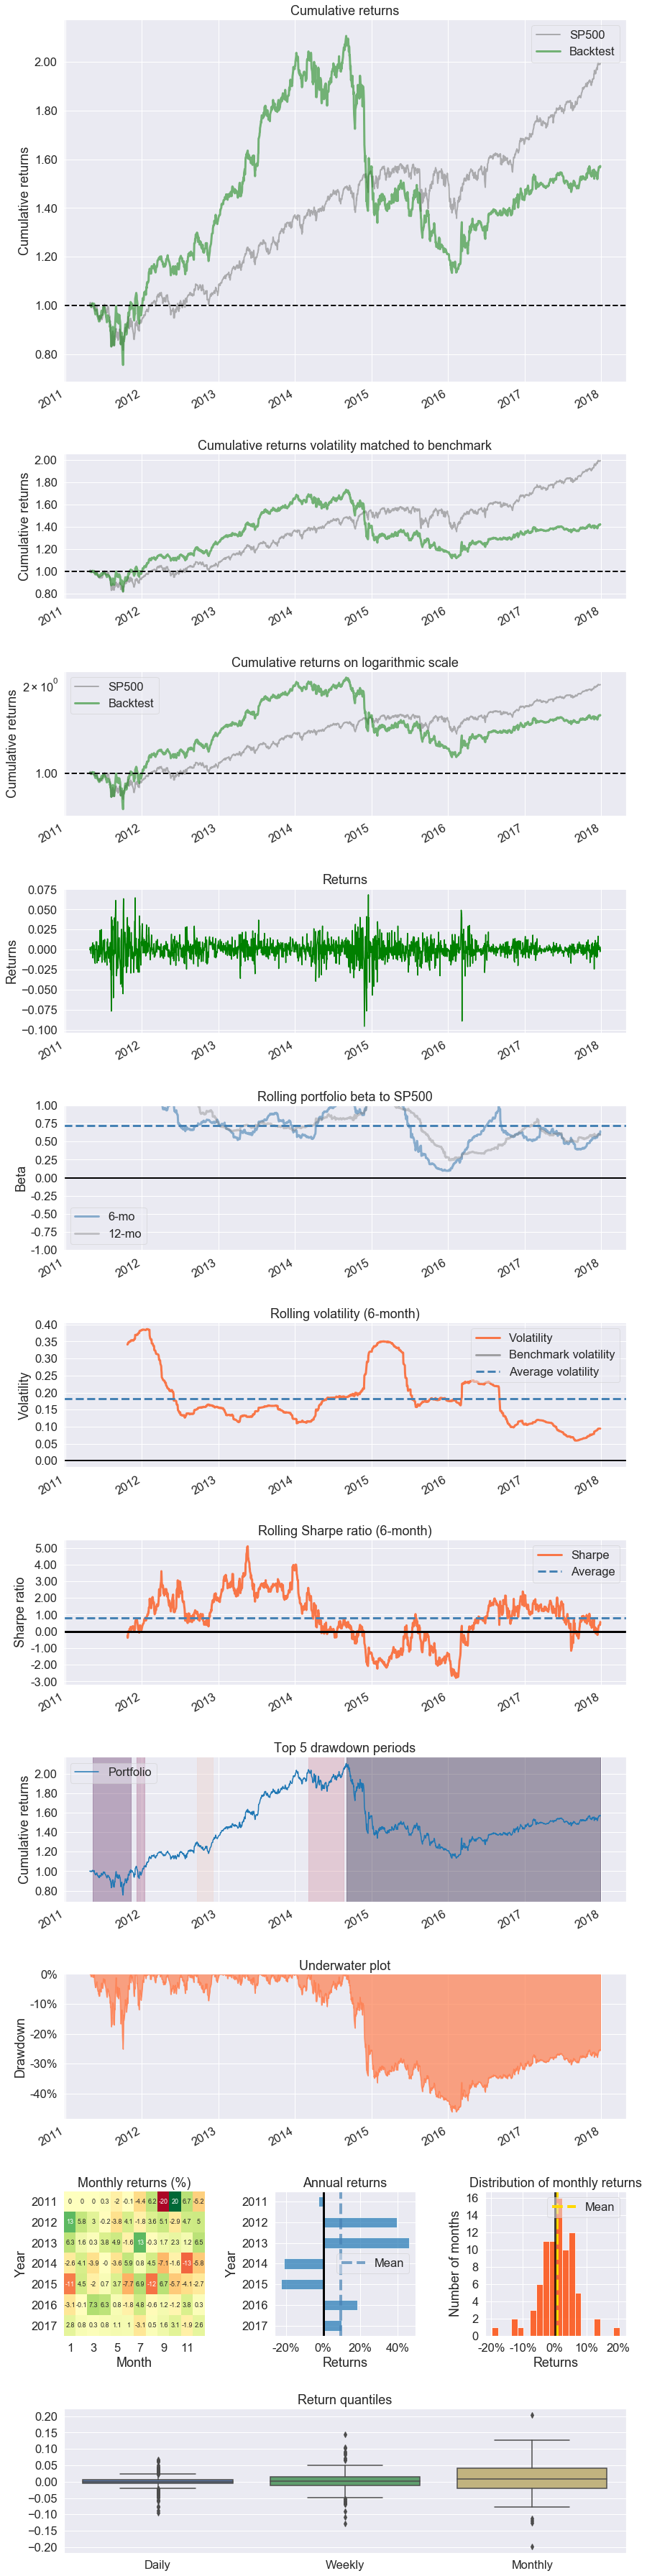

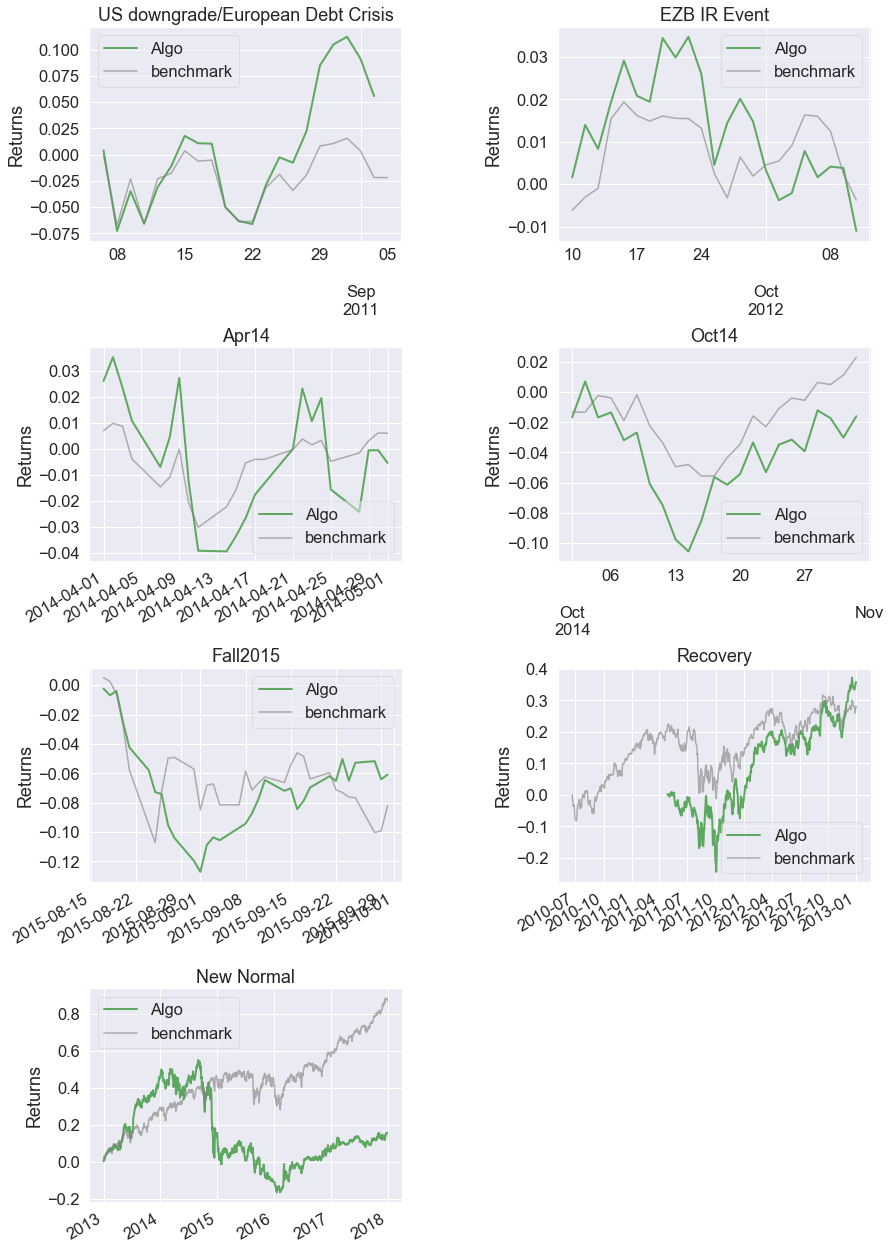

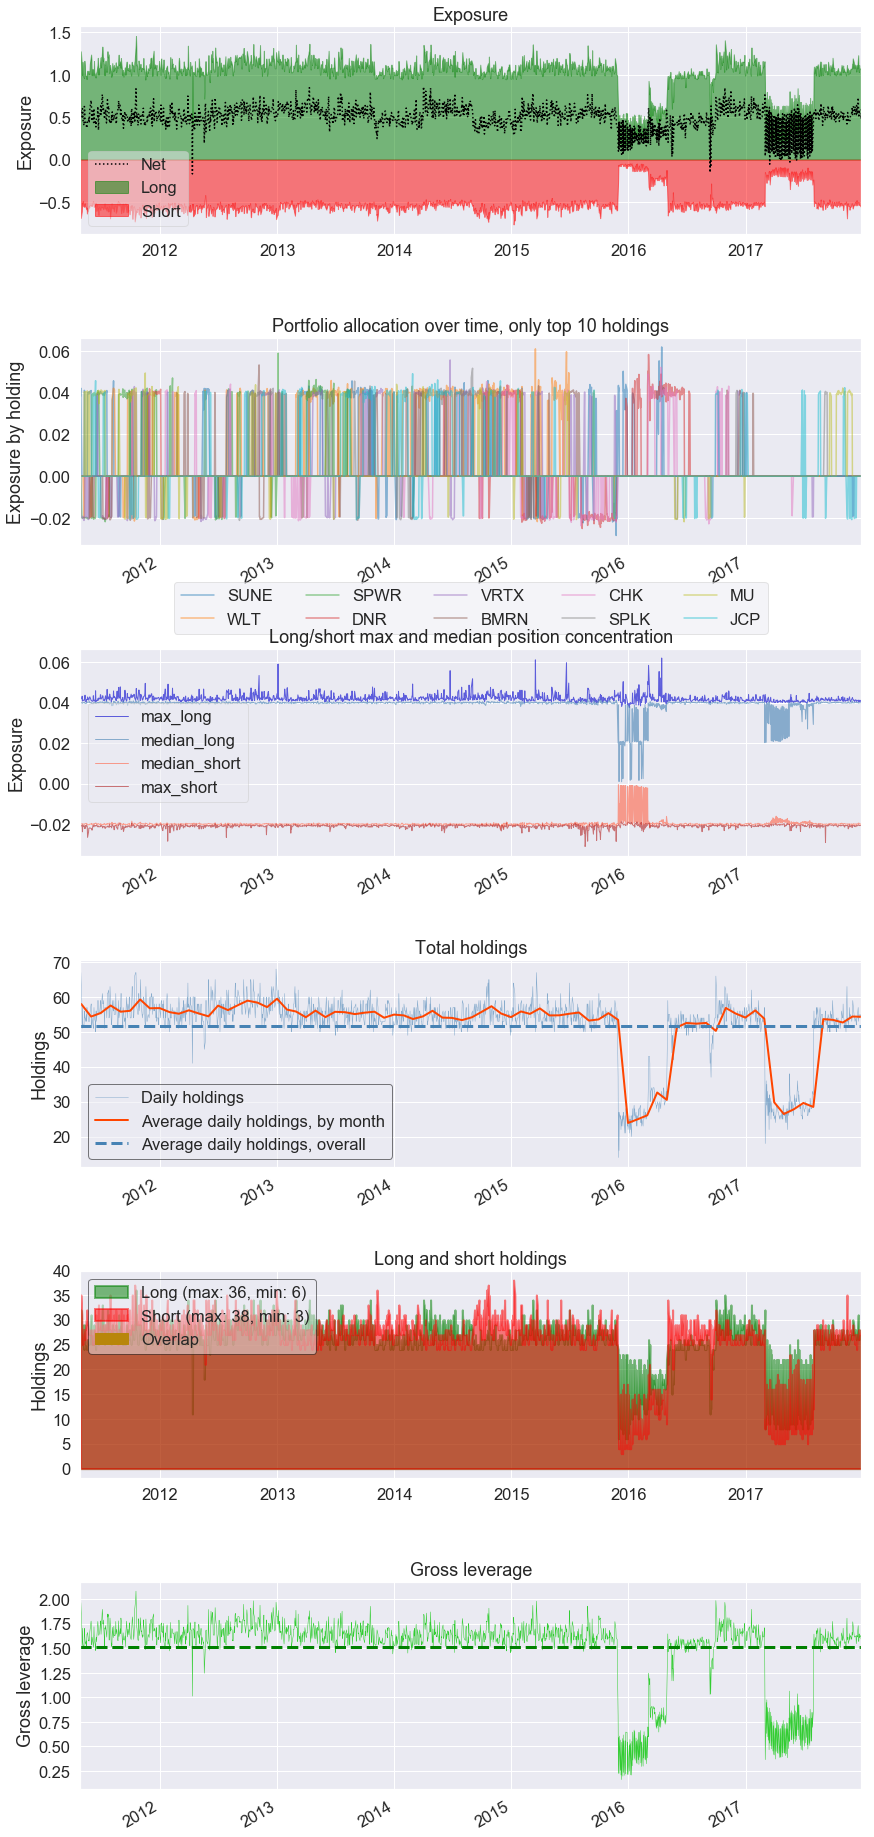

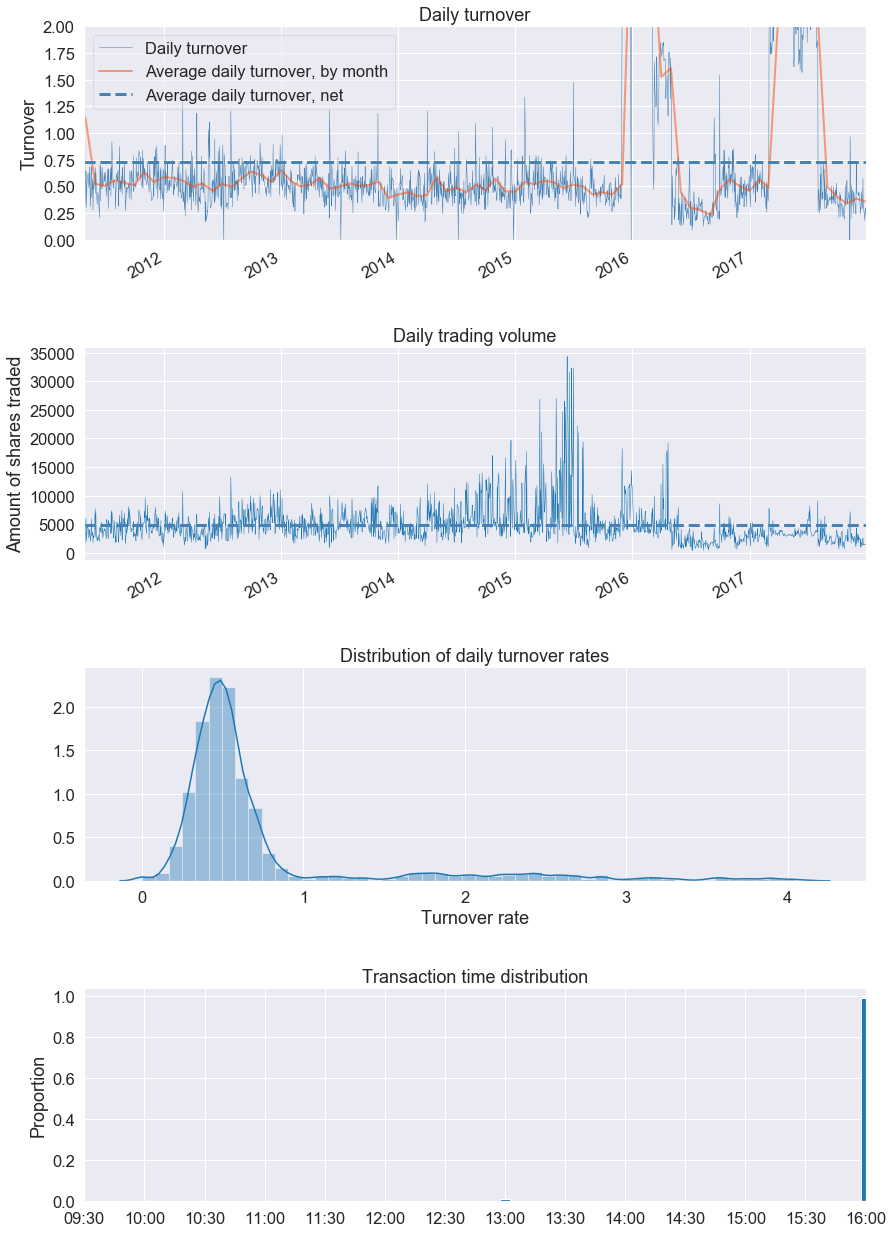

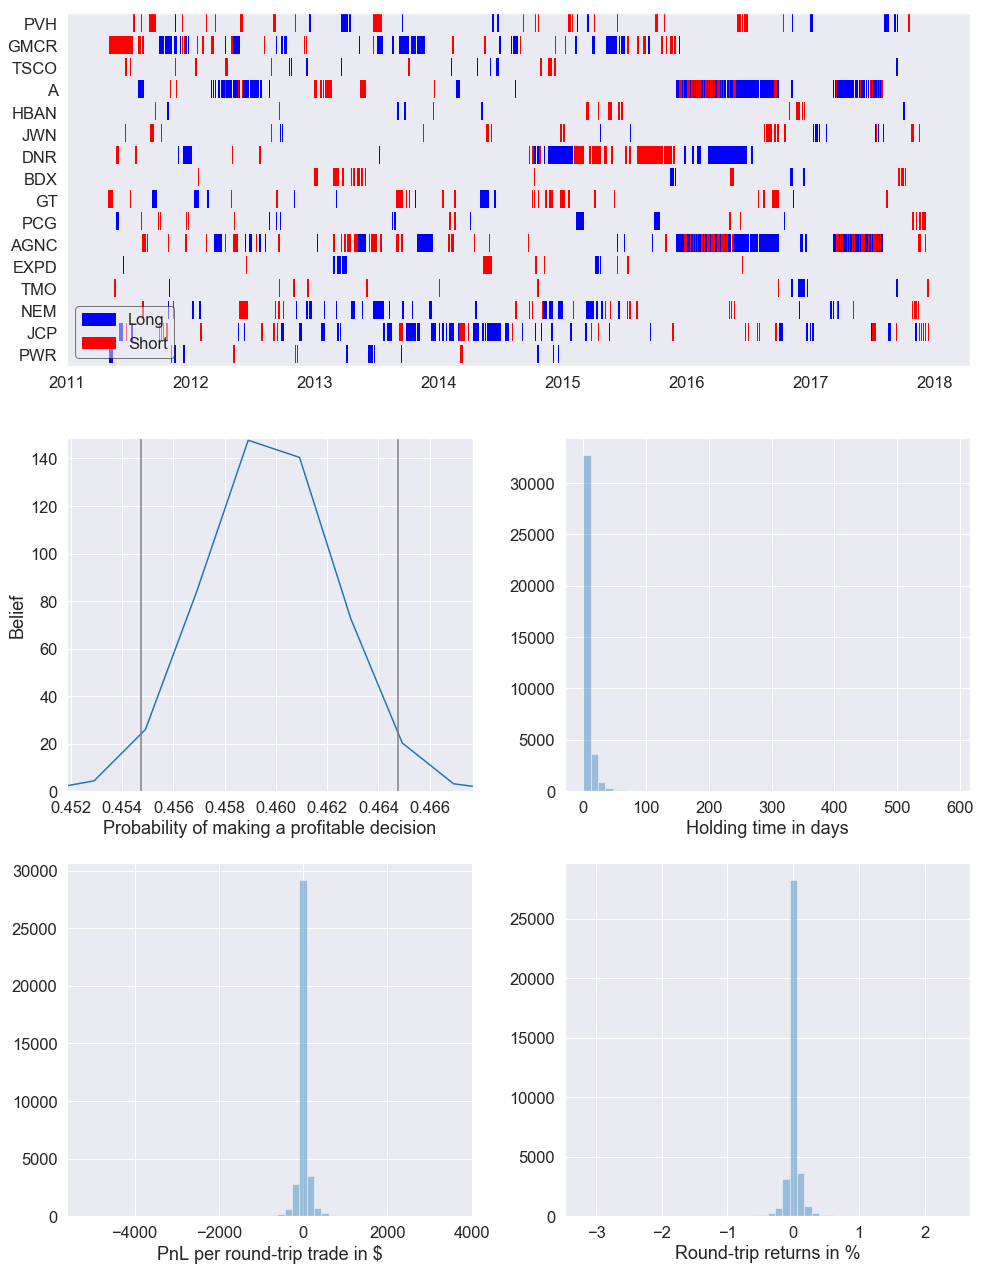

In [48]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)